# **The quantum werewolf**
Our game is a quantum version of the role game: "Werewolf". The main idea is that each character's state is represented by a qubit state, and that each role can apply a gate on a quantum circuit. 

Indeed, each character starts in the $\ket{0}$ state meaning "alive", while the $\ket{1}$ state means "dead". Some role-specific actions, such as described below, are able to change the quantum state of some players to bring them closer to death...

In the morning, when the village wakes up, the quantum circuit created and updated during the night will be measured in the Z-basis. If the outcome of the measurement for a player is the state $\ket{1}$ then the player is dead. Else if the state measured is $\ket{0}$, the player lives for another day.  

## **Goal of the game - Winning conditions**
Two different parties are fighting, the village and the werewolves. The villagers wants to kill the werewolves to protect themself, while the werewolves wants to kill all the villagers. 

There's some cases that can trigger the end of the game. 
1. If all the werewolves have been eliminated, then the village has won. 
2. If the number of werewolves is more than half of the village, then the werewolves have won, because they will eventually kill all of the village.

## **Presentation of the roles - Game mechanics**

#### **Proceeding of an entire tour - a Night and a Day**

#### **NIGHT**
During the night, the village is asleep, but most of the characters have a specific role to play when they are called by the Game Master. Below are presented the different roles in the same order as they would be called by the Game  Master.

Note that the night begins with the creation of a Quantum Circuit, that will contain the states of all the players in a state different of the initial state $\ket{0}$. We begin with a Quantum Circuit with only one qubit, since at least one player is going to be charged by the Werewolves and then will undergo a quantum state change.

In [1]:
from Night import *
from qiskit import QuantumCircuit

# In order to create a Night instance, we need to have an example list of players and roles.
# In practice, the roles are assigned randomy to the players, but for this example, we will deal with a simple fixed set of players and roles.

# The players will be numeroted from 0 to 10, and will have the following roles in the same order: 
# Here for example 2 villagers and 2 Werewolves, 1 Cupid, 1 Witch, 1 Hunter, 1 Seer, 1 Captain, 1 Thief and 1 Savior.
active_player_roles = ["Villager","Villager",  "Werewolf", "Werewolf", "Cupid", "Witch", "Hunter", "Seer", "Captain", "Thief", "Savior"]

# initiate the Witch power
witch_power = [True, True]  # [can_heal, can_attack]

#### **-> Cupid**
Cupid can play his role only during the first night of the game. His role is to choose two lovers which will be entangled for the rest of the game. When two players are lovers, they are affected by a control gate each night before the measurement of the circuit. That has the effect of killing both if one is measured on $\ket{1}$, because of the projective measurement.

For implementation purposes, that CNOT gate will be apply at the end of the night (see below).

Since Cupid only has a role during the first night, he is in practice called before to instantiate an instance of the class Night, to decide which players will be lovers and have their destiny linked forever.

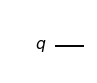

In [2]:
# initiate the couple chosen by Cupid
couple = couple = [1,6]

# create a Night instance
night = Night(active_player_roles, witch_power, couple)
(night.qc).draw('mpl', scale = 0.7, style='clifford')

Note that the actual player experience is much more funny! The lovers, and all the players targeted by some specific action will be provided by the Game Master who will have to input the names of the players (an internal function converts from names to indexes) in the terminal.

#### **-> The Seer**
The Seer has the same ability as in the classical game. The player can see the role of another player.

In [3]:
# Player whose the Seer wants to see the role
player_index = 6
player_role = night.Seer(player_index)
print(player_role)

Hunter


#### **-> The Werewolves**
During the night, the werewolves vote for a player that they want to affect with their gate. The unfortunate player is affected by the gate $R_X(\frac{2\pi}{3})$. That gate then creates a superposition state $\frac{\ket{0} -i \sqrt{3}\ket{1}}{2}$, implying that the affected player has now has $75$% probability to die because of his injuries caused by the Werewolves' attack, when the measurement is realized on the morning.

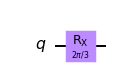

In [4]:
# Players the Werewolves want to attack
player_index = 1
night.Werewolf(player_index)

# updated Quantum Circuit
night.qc.draw('mpl', scale = 0.7, style='clifford')

#### **The Witch**
The witch can apply two different gates during the game, corresponding respectively to the heal and attack powers. The player can decide which gate he wants to apply for a given turn. The whitch can only apply these gates once each in the game. 

The attacking gate is simply a $R_X(\frac{\pi}{3})$ gate on the targeted player, and the save gate is a $R_X(\frac{-\pi}{3})$ so that the probability of measuring $\ket{1}$ is greater or lower. 

[True, False]


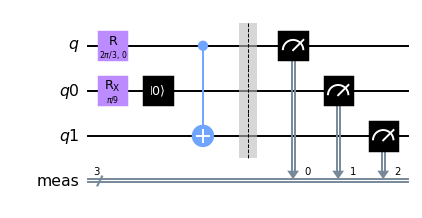

In [12]:
# Suppose the Witch wants to heal the player who has been attacked by the Werewolves
# (Note: in the actual gameplay, the Witch will be asked if she wants to heal or attack, and will choose one of the two actions)

night.Witch(save_attacked_player=False, attack_player_index= 0)

# updated Quantum Circuit after the Witch's action, and updated witch_power
print(night.witch_ability)
night.qc.decompose().draw('mpl', scale = 0.7, style='clifford')

#### **The Saviour**
The saviour is the protector of the village. He has a special ability that he can do once per turn. The saviour can reset the qubit of a player to the $\ket{0}$ state. The probability of the targeted player dying is then reset to zero, as the state is no longer a superposition state. 
If the player to protect is not already endangered, nothing is done.

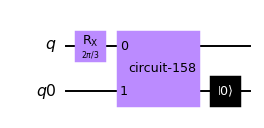

In [6]:
# Player to protect
player_index = 0

night.Savior(player_index)

night.qc.draw('mpl', scale = 0.7, style='clifford')


#### **The Thief**
The thief can exchange role with another player of his choice. The idea behind this role is a swap gate between the two players. The swap gate is only applied if the two players have been attacked. If not, we change their indices to acces their qubits. The thief change role and quantum state with the targeted player. 

In [7]:
# Player to rob
player_index = 4
active_player_roles = night.Thief(player_index)

# updated active_player_roles after the Thief's action
print(active_player_roles)

['Villager', 'Villager', 'Werewolf', 'Werewolf', 'Thief', 'Witch', 'Hunter', 'Seer', 'Captain', 'Cupid', 'Savior']


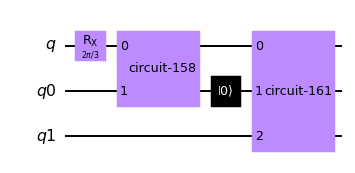

In [8]:
# The night is now over
night_qc, endangered_players = night.Finish_Night()

# updatated Quantum Circuit after the night is over
night_qc.draw('mpl', scale = 0.7, style='clifford')

#### **DAY**

In [9]:
from Day import *

# Creates an instance of Day
day = Day(night_qc, endangered_players, active_player_roles, couple)


# On the morning, the quantum states of endangered players are measured to determine which players died during the night.
dead_players, active_player_roles = day.night_measures()

print(dead_players, active_player_roles)

[1, 1] ['Villager', 'Villager', 'Werewolf', 'Werewolf', 'Thief', 'Witch', 'Hunter', 'Seer', 'Captain', 'Cupid', 'Savior']


#### **-> The Hunter**

That night has been turbulent! The Hunter has been killed (if measured on $\ket{1}$ above)...

The hunter is a simple villager until he dies. When he's measured at the state $\ket{1}$, that is to say when he dies, the hunter can target a player to affect with his gate $R_X(2\arcsin(\sqrt{0.9}))$. That get has the effect that the next measurement on the targeted player will kill him with a probability of 90%. As a matter of fact, the qubit of the targeted player is instantly measured, killing or not the targeted player based on the measurement result. The hunter then dies too, as he is supposed to.

#### **The Captain**
This role is also much of a classical role. The captain has two votes instead of only one during the vote phase.

## **Running the game**
We implemented the game such that you can play it as the master of the game and use it to direct the game according to what the code tells you.

In [10]:
# Some imports to visualize the circuits 
from qiskit import QuantumCircuit

In [11]:
a = [1,1,2,1,3,4]
a.count(1)

3